# Gemini bounding boxes

This notebook attempts to use Gemini in order to extract AABB (axis-aligned bounding boxes) from the PDF.

Two approaches are included (uncomment the one you want to use):
- Prompting for normalized coordinates with PDF as input (default)
- Prompting for absolute coordinates with PNG as input (commented)

## Libraries used:
- vertexai & google-cloud-aiplatform
- pypdf
- PyMuPDF (fitz)
- Pillow (PIL)

## Documents used:
- [minnie_mouse.pdf](./minnie_mouse.pdf)

## Results

Unfortunately, the results are not even close to being satisfactory.

In [3]:
PROJECT_ID = 'viki-dev-app-wsky'
LOCATION = 'us-central1'
MODEL = 'gemini-1.5-pro-preview-0409'

In [44]:
from typing import List, Union, Tuple
from io import BytesIO

import vertexai
from vertexai.language_models import TextGenerationModel, TextEmbeddingModel
from vertexai.generative_models import GenerativeModel, Part, FinishReason, HarmCategory, HarmBlockThreshold
from google.cloud import aiplatform
import pypdf
import fitz  # PyMuPDF
from IPython.display import display
from PIL import Image, ImageDraw

vertexai.init(project=PROJECT_ID, location=LOCATION)
aiplatform.init(project=PROJECT_ID, location=LOCATION)

async def multi_modal_predict(items: List[Union[str, Tuple[bytes, str]]], model="gemini-1.5-pro-preview-0409"):
    """
    `items` is a list of tuples, where each tuple is either a string or a tuple of bytes and a string of the mime type.

    e.g.:
    items = [
        "This is a string",
        (b"this is a byte string", "application/pdf"),
        (b"this is a byte string", "image/jpeg"),
    ]
    """

    contents = []
    for item in items:
        if isinstance(item, str):
            contents.append(Part.from_text(item))
        else:
            contents.append(Part.from_data(data=item[0], mime_type=item[1]))

    generation_config = {
        "max_output_tokens": 8192,
        "temperature": 1,
        "top_p": 0.95,
    }

    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    }

    model = GenerativeModel(model)
    return await model.generate_content_async(
        contents,
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=True,
    )

Single-page PDF size: 133612


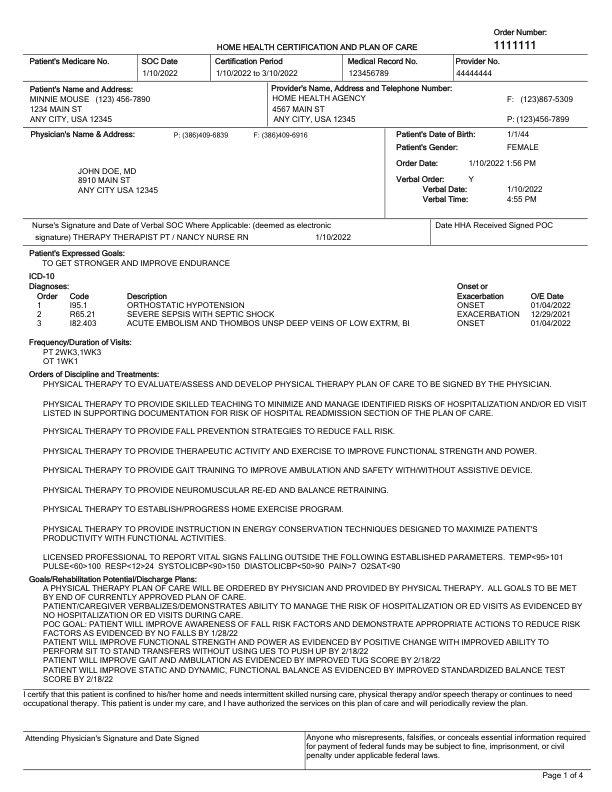

- HOME HEALTH CERTIFICATION AND PLAN OF CARE (0.383, 0.014, 0.841, 0.034)
- Patient's Medicare No. (0.047, 0.066, 0.207, 0.086)
- SOC Date (0.231, 0.066, 0.302, 0.086)
- 1/10/2022 (0.325, 0.066, 0.402, 0.086)
- Certification Period (0.383, 0.066, 0.541, 0.086)
- 1/10/2022 to 3/10/2022 (0.555, 0.066, 0.729, 0.086)
- Medical Record No. (0.608, 0.066, 0.766, 0.086)
- 123456789 (0.608, 0.087, 0.709, 0.107)
- Patient's Name and Address: (0.047, 0.108, 0.264, 0.128)
- MINNIE MOUSE (123) 456-7890 (0.047, 0.129, 0.288, 0.149)- HOME HEALTH CERTIFICATION AND PLAN OF CARE (0.383, 0.014, 0.841, 0.034)
- Patient's Medicare No. (0.047, 0.066, 0.207, 0.086)
- SOC Date (0.231, 0.066, 0.302, 0.086)
- 1/10/2022 (0.325, 0.066, 0.402, 0.086)
- Certification Period (0.383, 0.066, 0.541, 0.086)
- 1/10/2022 to 3/10/2022 (0.555, 0.066, 0.729, 0.086)
- Medical Record No. (0.608, 0.066, 0.766, 0.086)
- 123456789 (0.608, 0.087, 0.709, 0.107)
- Patient's Name and Address: (0.047, 0.108, 0.264, 0.128)
- MINNIE MOU

In [95]:
# Read first page
pdf_reader = pypdf.PdfReader('./minnie_mouse.pdf')
page = pdf_reader.pages[0]

# Save first page as separate PDF
page_pdf_buffer = BytesIO()
page_writer = pypdf.PdfWriter()
page_writer.add_page(page)
page_writer.write(page_pdf_buffer)
page_pdf_buffer.seek(0)
page_pdf_content = page_pdf_buffer.getvalue()
print(f'Single-page PDF size: {len(page_pdf_content)}')

# Open page with PyMuPDF
doc = fitz.open(stream=page_pdf_content)
# Get first (and only) page
page = doc[0]
# Extract as PNG
pixmap = page.get_pixmap(matrix=fitz.Matrix(1.0, 1.0))  # Scale by 1x1
png_data = pixmap.tobytes()

# Construct PIL image
img = Image.open(BytesIO(png_data))
draw = ImageDraw.Draw(img)

display(img)

# PDF with normalized coords:
response = await multi_modal_predict([
    'Extract text from the following document:',
    (page_pdf_content, 'application/pdf'),
    'For each block, include an axis-aligned bounding box with normalized coordinates of X1,Y1,X2,Y2 of the box. ',
    'Coordinate (0.0, 0.0) is top-left of the page, (1.0, 1.0) is bottom-right of the page.\n',
    'Example response:\n',
    '''
    - This is a text (0.01, 0.13, 0.8, 0.23)
    - This is another text (0.27, 0.45, 0.551, 0.21)

    Limit your output to 10 results only.
    ''',
])

# PNG with absolute coords:
# response = await multi_modal_predict([
#     'Extract text from the following document:',
#     (png_data, 'image/png'),
#     'For each block, include an axis-aligned bounding box with coordinates of X1,Y1,X2,Y2 of the box. ',
#     f'Coordinate (0, 0) is top-left of the page, ({img.width}, {img.height}) is bottom-right of the page.\n',
#     'Example response:\n',
#     '''
#     - This is a text (100, 100, 800, 200)
#     - This is another text (100, 300, 600, 180)

#     Limit your output to 10 results only.
#     ''',
# ])

results = []
async for chunk in response:
    print(chunk.text, end='')
    results.append(chunk.text)

result = ''.join(results)
print(result)

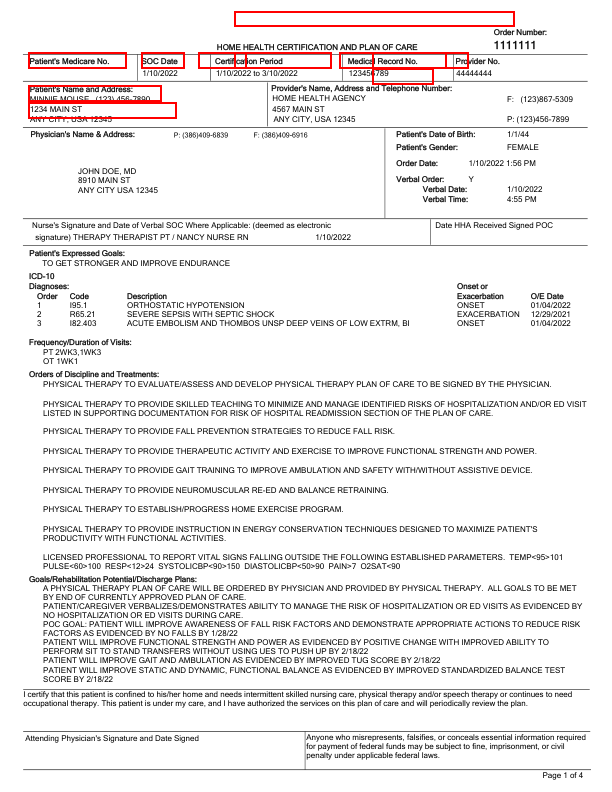

In [96]:
import re

img_w, img_h = img.size

for line in result.split('\n'):
    match = re.match(r'\s*(.*)\s*\(([\d\., ]+)\)', line)
    if match:
        text, coords = match.groups()
        x1, y1, x2, y2 = [float(x.strip()) for x in coords.split(',')]
        # For PDF with normalized coords:
        draw.rectangle([x1 * img_w, y1 * img_h, x2 * img_w, y2 * img_h], outline='red', width=2)
        # For PNG with absolute coords:
        # draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

img